# Import

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
%matplotlib inline

In [3]:
!mkdir plots
!mkdir results

mkdir: cannot create directory ‘plots’: File exists
mkdir: cannot create directory ‘results’: File exists


# Useful functions

In [3]:
def set_ticks(ax, xMin, yMin, ax2, y2Min):

    # first axis
    ax.tick_params(which='major', right=False, width=1.0, length=8, direction="in", labelsize=12)
    ax.tick_params(which='minor', right=False, width=1.0, length=4, direction="in", labelsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(xMin))
    ax.yaxis.set_minor_locator(AutoMinorLocator(yMin))

    # second axis
    ax2.tick_params(which='major', right=True, width=1.0, length=8, direction="in", labelsize=12, color='firebrick')
    ax2.tick_params(which='minor', right=True, width=1.0, length=4, direction="in", labelsize=12)
    ax2.yaxis.set_minor_locator(AutoMinorLocator(y2Min))   

In [7]:
def efficiency(x, a, b, v0):
    '''
        efficiency function.
    '''
    return a / (1 + np.exp(-b * (x - v0)))

def rate_function(x, a, b, r0):
    '''
        Exponential function.
    '''
    return np.exp(a + b * x) + r0


def get_rate_error(x, s_x, a, s_a, b, s_b, r0, s_r0, c_ab , c_ar0, c_br0):
    '''
        Compute error of the expected rate from fit.
    '''
    # term with covariance
    cov_term =  2 * np.exp(a + b * x) * (x * np.exp(a + b * x) * c_ab + c_ar0 + x * c_br0)
    # error by propagating
    error = np.sqrt(s_r0**2 + np.exp(a + b * x)**2 * (s_a**2 + b**2 * s_x**2 + x**2 * s_b**2) + cov_term) 
    
    return error

def get_plateau_voltage(threshold, b, s_b, v0, s_v0):
    '''
        Compute plateau voltage and its error.
    '''

    # optimal voltage
    x = np.log((1 / threshold) - 1)
    voltage = v0 + x / b

    # error by propagating
    error = np.sqrt(s_v0**2 + x**2 * s_b**2 / b**4)
    
    return voltage, error

def find_min_max(list1, list2):

    # min
    min1, min2 = np.min(list1), np.min(list2)
    if min1 < min2:
        min_rate = min1
    else:
        min_rate = min2 

    # max
    max1, max2 = np.max(list1), np.max(list2)
    if max1 > max2:
        max_rate = max1
    else:
        max_rate = max2
    
    return min_rate, max_rate


def get_asym_err(y, err):
    '''
        compute asymmetric errors 
    '''

    asym_err = []
    
    for e, s in zip(y, err):
        if e+s > 1.:
            asym_err.append([s,1-e])
        else:
            asym_err.append([s,s])

    return np.array(asym_err).T


def dump_results(file, names, fit, errors):
    for name, fit, s_fit in zip(names, fit, errors):
        file.write(name + " = " + str(fit) + " +- " + str(s_fit) + "\n")


# Analysis

In [18]:
def plot_efficiency(ax, filename, title, save=True):

    # unpack data
    x, _, _, _, eff, _, _, _, s_eff, rate, s_rate = np.loadtxt(filename, unpack=True)

    # fit
    pms_eff, _ = op.curve_fit(efficiency, x, eff, sigma=s_eff,
                              bounds=((0.7, 0.01, 1500), (1.3, 0.12, 2000)))
    pms_rate, _ = op.curve_fit(rate_function, x, rate, sigma=s_rate,
                               bounds=((-30, 0.01, -20), (-10, 0.03, 10)))

    # evaluate errors on efficiency
    s_eff_asym = get_asym_err(eff,s_eff)

    # efficiency
    domain = np.linspace(min(x), max(x), 50)
    ax.plot(domain, efficiency(domain, *pms_eff), color='forestgreen', ls='-', alpha=0.3, lw=3)
    ax.errorbar(x, eff, yerr=s_eff_asym, marker='o', mec='white', markersize=9, 
                color='forestgreen', linestyle='none', label='Efficiency', capsize=4)

    # # pay attention to the case eff > 1
    # for r, e, se in zip(x, eff, s_eff):
    #     if e + se > 1:
    #         ax.errorbar(r, e, yerr=se, marker='o', mec='white', markersize=9, 
    #                     color='forestgreen', linestyle='none', uplims=True)
    #     else:
    #         ax.errorbar(r, e, yerr=se, marker='o', mec='white', markersize=9, 
    #                     color='forestgreen', linestyle='none')

    # rate
    ax2 = ax.twinx()
    ax2.plot(domain, rate_function(domain, *pms_rate), color='firebrick', ls='-', alpha=0.3, lw=3)
    ax2.errorbar(x, rate, yerr=s_rate, marker='o', mec='white', markersize=9, 
                color='firebrick', linestyle='none', label='Rate', capsize=4)

    # set a better range
    ax2.set_ylim(min(rate)-5, max(rate)+100)

    # labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Efficiency", fontsize=14)
    ax.set_xlabel("HV [V]", fontsize=14)
    ax2.set_ylabel("Rate [Hz]", fontsize=14)

    # highlight axis
    ax2.spines['right'].set_color('firebrick')
    ax2.yaxis.label.set_color('firebrick') 
    ax2.tick_params(axis='y', colors='firebrick')

    # legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=13, frameon=False)

    # save
    if save:
        name, _ = os.path.splitext(filename)
        fig.savefig("plots/" + name + ".pdf")

In [10]:
def plot_efficiency_both(ax, filename_near, filename_far, title, filename_results, threshold=0.02):

    # unpack data
    x_near, _, _, _, eff_near, _, _, _, s_eff_near, rate_near, s_rate_near = np.loadtxt(filename_near, unpack=True)
    x_far, _, _, _, eff_far, _, _, _, s_eff_far, rate_far, s_rate_far = np.loadtxt(filename_far, unpack=True) 

    # fit near
    pms_eff_near, cov_eff_near = op.curve_fit(efficiency, x_near, eff_near, sigma=s_eff_near,
                              bounds=((0.7, 0.01, 1500), (1.3, 0.12, 2000)))
    pms_rate_near, cov_eff_far = op.curve_fit(rate_function, x_near, rate_near, sigma=s_rate_near,
                               bounds=((-30, 0.01, -20), (-10, 0.03, 10)))

    # errors
    cov_eff_near_d, cov_eff_far_d = np.diagonal(cov_eff_near), np.diagonal(cov_eff_far)
    err_eff_near, err_eff_far = np.sqrt(cov_eff_near_d), np.sqrt(cov_eff_far_d)

    # fit near
    pms_eff_far, cov_rate_near = op.curve_fit(efficiency, x_far, eff_far, sigma=s_eff_far,
                              bounds=((0.7, 0.01, 1500), (1.3, 0.12, 2000)))
    pms_rate_far, cov_rate_far = op.curve_fit(rate_function, x_far, rate_far, sigma=s_rate_far,
                               bounds=((-30, 0.01, -20), (-10, 0.03, 10)))

    # errors
    cov_rate_near_d, cov_rate_far_d = np.diagonal(cov_rate_near), np.diagonal(cov_rate_far)
    err_rate_near, err_rate_far = np.sqrt(cov_rate_near_d), np.sqrt(cov_rate_far_d)

    # covariance between a, b and r0 for rate fit
    cov_rate_near_ab, cov_rate_far_ab = cov_rate_near[0,1], cov_rate_far[0,1]
    cov_rate_near_ar0, cov_rate_far_ar0 = cov_rate_near[0,2], cov_rate_far[0,2]
    cov_rate_near_br0, cov_rate_far_br0 = cov_rate_near[1,2], cov_rate_far[1,2]

    # compute saturation voltage on the far curve
    p_voltage, s_p_voltage = get_plateau_voltage(threshold, pms_eff_far[1], err_eff_far[1], pms_eff_far[2], err_eff_far[2])

    # compute expected plateau rate
    p_rate = rate_function(p_voltage, *pms_rate_far)
    
    # compute error on expected plateau rate
    s_p_rate = get_rate_error(p_voltage, s_p_voltage, pms_rate_far[0], err_rate_far[0], pms_rate_far[1],
                                err_rate_far[1], pms_rate_far[2], err_rate_far[2], cov_rate_far_ab, cov_rate_far_ar0, cov_rate_far_br0)


    # open file
    file = open("results/" + filename_results, 'a')

    # dump fit parameters on file
    names_eff = ['a', 'b', 'v0']
    file.write("\nAnalyzing: " + filename_near + " and " + filename_far + "\n")
    file.write("\nEFFICIENCY NEAR:\n")
    dump_results(file, names_eff, pms_eff_near, err_eff_near)
    file.write("EFFICIENCY FAR:\n")
    dump_results(file, names_eff, pms_eff_far, err_eff_far)
    names_rate = ['a', 'b', 'r0']
    file.write("RATE NEAR:\n")
    dump_results(file, names_rate, pms_rate_near, err_rate_near)
    file.write("RATE FAR:\n")
    dump_results(file, names_rate, pms_rate_far, err_rate_far)
    file.write("\n")
    file.write("V_P = " + str(p_voltage) + " +- " + str(s_p_voltage) + "\n")
    file.write("R_P = " + str(p_rate) + " +- " + str(s_p_rate) + "\n")
    file.write("\n")

    # close file
    file.close()

    # print on screen
    t = "$V_P$ = %.2f +- %.2f V\n$R_P$ = %.2f +- %.2f Hz" % (p_voltage, s_p_voltage, p_rate, s_p_rate)
    ax.text(0.025, 0.875, t, transform = ax.transAxes, fontsize=13)

    # efficiency near
    domain = np.linspace(min(x_near), max(x_near), 50)
    ax.plot(domain, efficiency(domain, *pms_eff_near), color='forestgreen', ls='-', alpha=0.3, lw=3)
    ax.errorbar(x_near, eff_near, yerr=s_eff_near, marker='o', mec='white', markersize=9, 
                color='forestgreen', linestyle='none', capsize=4, label='Efficiency (near)')

    # rate near
    ax2 = ax.twinx()
    ax2.plot(domain, rate_function(domain, *pms_rate_near), color='firebrick', ls='-', alpha=0.3, lw=3)
    ax2.errorbar(x_near, rate_near, yerr=s_rate_near, marker='o', mec='white', markersize=9, 
                color='firebrick', linestyle='none', label='Rate (near)', capsize=4)

    # efficiency far
    domain = np.linspace(min(x_far), max(x_far), 50)
    ax.plot(domain, efficiency(domain, *pms_eff_far), color='royalblue', ls='--', alpha=0.3, lw=3)
    ax.errorbar(x_far, eff_far, yerr=s_eff_far, marker='D', mec='white', markersize=9, 
                color='royalblue', linestyle='none', capsize=4, label='Efficiency (far)')

    # rate far
    ax2.plot(domain, rate_function(domain, *pms_rate_far), color='darkred', ls='--', alpha=0.3, lw=3)
    ax2.errorbar(x_far, rate_far, yerr=s_rate_far, marker='D', mec='white', markersize=9, 
                color='darkred', linestyle='none', label='Rate (far)', capsize=4)

    # set a better range for the rate
    min_rate, max_rate = find_min_max(rate_near, rate_far)
    ax2.set_ylim(min_rate-25, max_rate+100)

    # set a better range for the efficiency
    _, max_eff = find_min_max(eff_near, eff_far)
    ax.set_ylim(-0.15, max_eff + 0.35)

    # labels
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Efficiency", fontsize=14)
    ax.set_xlabel("HV [V]", fontsize=14)
    ax2.set_ylabel("Rate [Hz]", fontsize=14)

    # ticks
    set_ticks(ax, 3, 2, ax2, 2)
    
    # highlight axis
    ax2.spines['right'].set_color('firebrick')
    ax2.yaxis.label.set_color('firebrick') 
    ax2.tick_params(axis='y', which='both', colors='firebrick')

    # legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=13, frameon=False)

## Final - 20220428

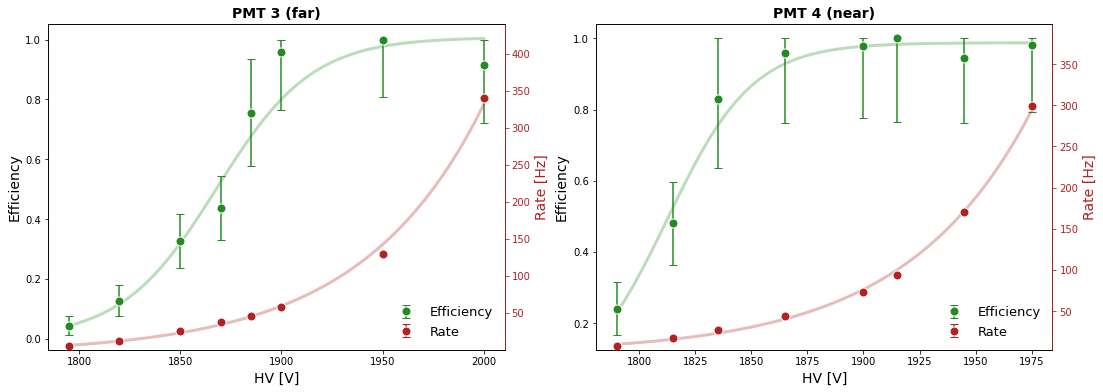

In [19]:
# data
titles = ["PMT 3 (far)", "PMT 4 (near)"]
files = ["data_PMT3_far.dat", "data_PMT4_near.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)
plot_efficiency(ax[0], files[0], titles[0], False)
plot_efficiency(ax[1], files[1], titles[1], False)

# save
fig.savefig("plots/plot_single_3-4.pdf")

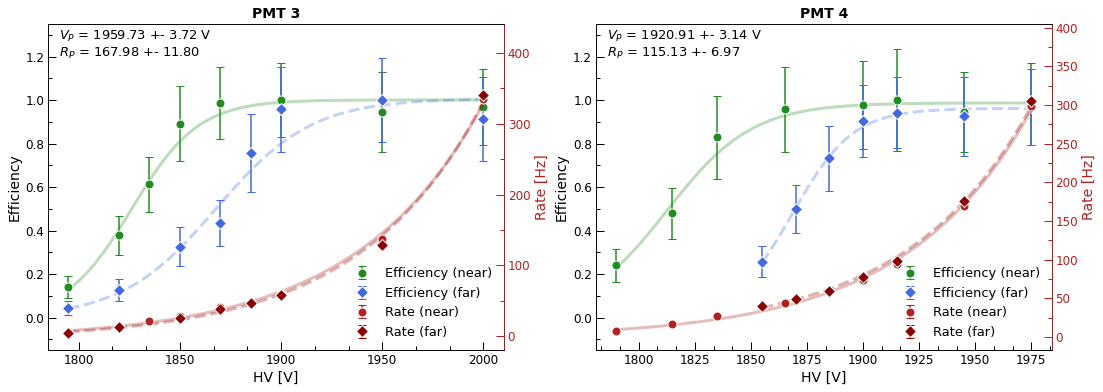

In [17]:
# data
titles = ["PMT 3", "PMT 4"]
files = ["data_PMT3_near.dat", "data_PMT3_far.dat", "data_PMT4_near.dat", "data_PMT4_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)
plot_efficiency_both(ax[0], files[0], files[1], titles[0], "results_PMT.txt")
plot_efficiency_both(ax[1], files[2], files[3], titles[1], "results_PMT.txt")

# save
fig.savefig("plots/plot_both_3-4.pdf")

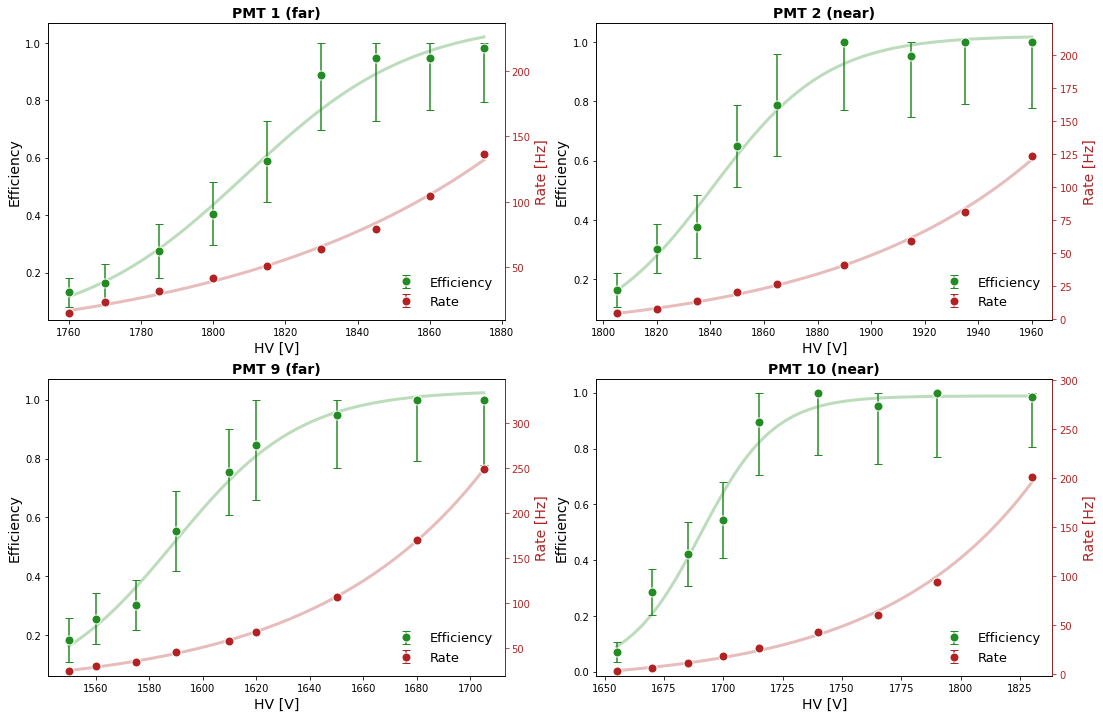

In [98]:
# data
titles = ["PMT 1 (far)", "PMT 2 (near)", "PMT 9 (far)", "PMT 10 (near)"]
files = ["data_PMT1_far.dat", "data_PMT2_near.dat", "data_PMT9_far.dat", "data_PMT10_near.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)

plot_efficiency(ax[0, 0], files[0], titles[0], False)
plot_efficiency(ax[0, 1], files[1], titles[1], False)
plot_efficiency(ax[1, 0], files[2], titles[2], False)
plot_efficiency(ax[1, 1], files[3], titles[3], False)

# save
fig.savefig("plots/plot_single_1-2-9-10.pdf")

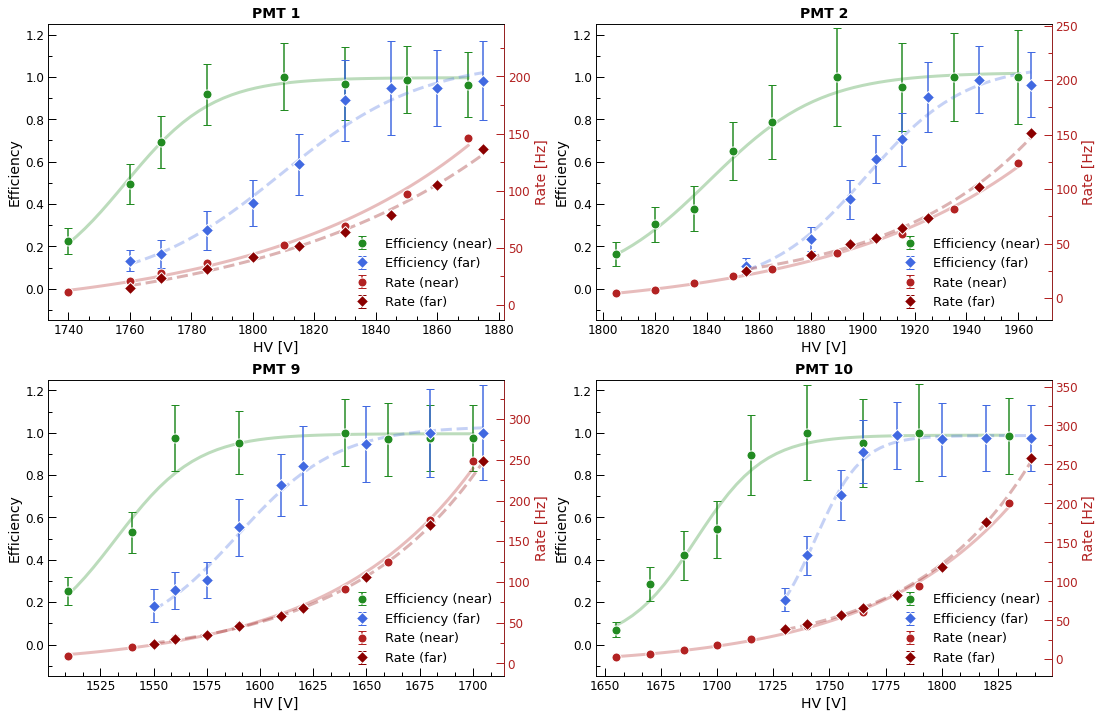

In [27]:
# data
titles = ["PMT 1", "PMT 2", "PMT 9", "PMT 10"]
files = ["data_PMT1_near.dat", "data_PMT1_far.dat", "data_PMT2_near.dat", "data_PMT2_far.dat",
         "data_PMT9_near.dat", "data_PMT9_far.dat", "data_PMT10_near.dat", "data_PMT10_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)
plot_efficiency_both(ax[0, 0], files[0], files[1], titles[0], "results_PMT.txt")
plot_efficiency_both(ax[0, 1], files[2], files[3], titles[1], "results_PMT.txt")
plot_efficiency_both(ax[1, 0], files[4], files[5], titles[2], "results_PMT.txt")
plot_efficiency_both(ax[1, 1], files[6], files[7], titles[3], "results_PMT.txt")

# save
fig.savefig("plots/plot_both_1-2-9-10.pdf")

## Final - 20220502

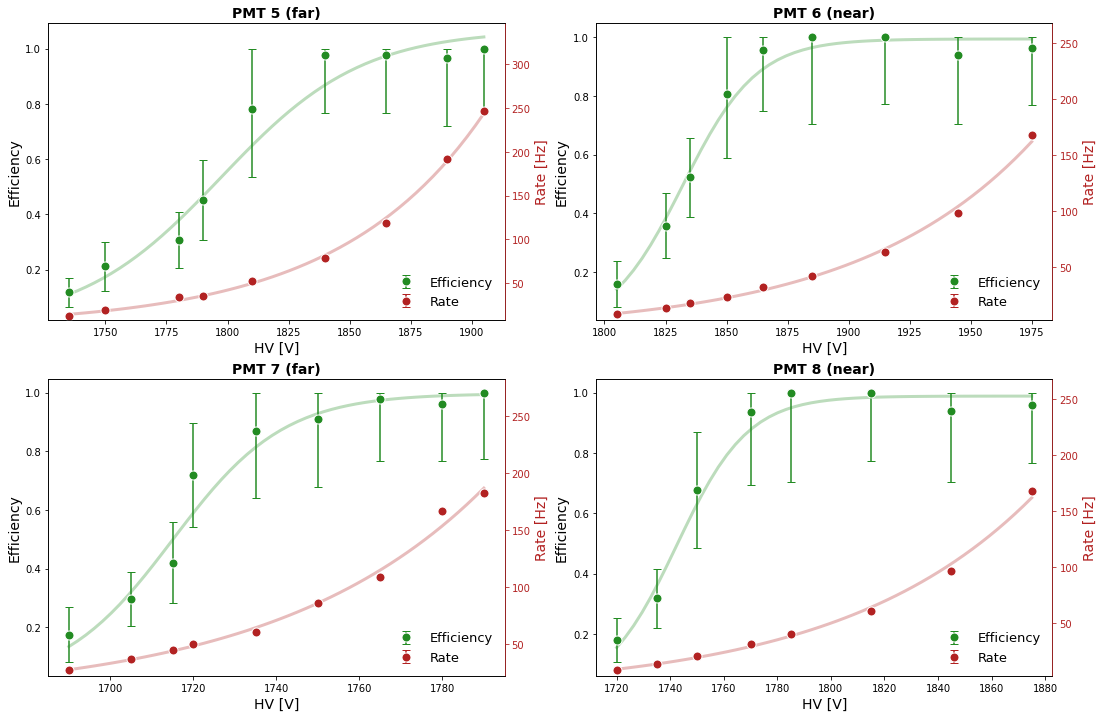

In [99]:
# data
titles = ["PMT 5 (far)", "PMT 6 (near)", "PMT 7 (far)", "PMT 8 (near)"]
files = ["data_PMT5_far.dat", "data_PMT6_near.dat", "data_PMT7_far.dat", "data_PMT8_near.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)

plot_efficiency(ax[0, 0], files[0], titles[0], False)
plot_efficiency(ax[0, 1], files[1], titles[1], False)
plot_efficiency(ax[1, 0], files[2], titles[2], False)
plot_efficiency(ax[1, 1], files[3], titles[3], False)

# save
fig.savefig("plots/plot_single_5-6-7-8.pdf")

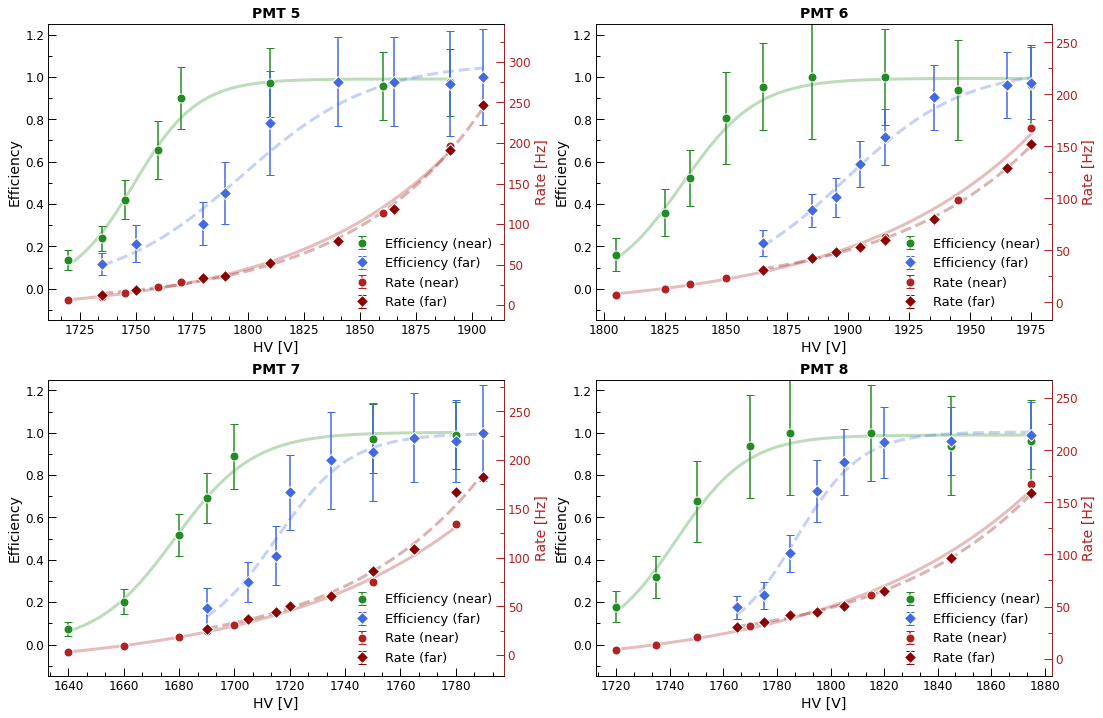

In [35]:
# data
titles = ["PMT 5", "PMT 6", "PMT 7", "PMT 8"]
files = ["data_PMT5_near.dat", "data_PMT5_far.dat", "data_PMT6_near.dat", "data_PMT6_far.dat",
         "data_PMT7_near.dat", "data_PMT7_far.dat", "data_PMT8_near.dat", "data_PMT8_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)
plot_efficiency_both(ax[0, 0], files[0], files[1], titles[0], "results_PMT.txt")
plot_efficiency_both(ax[0, 1], files[2], files[3], titles[1], "results_PMT.txt")
plot_efficiency_both(ax[1, 0], files[4], files[5], titles[2], "results_PMT.txt")
plot_efficiency_both(ax[1, 1], files[6], files[7], titles[3], "results_PMT.txt")

# save
fig.savefig("plots/plot_both_1-2-9-10.pdf")

## Final plot - condensed

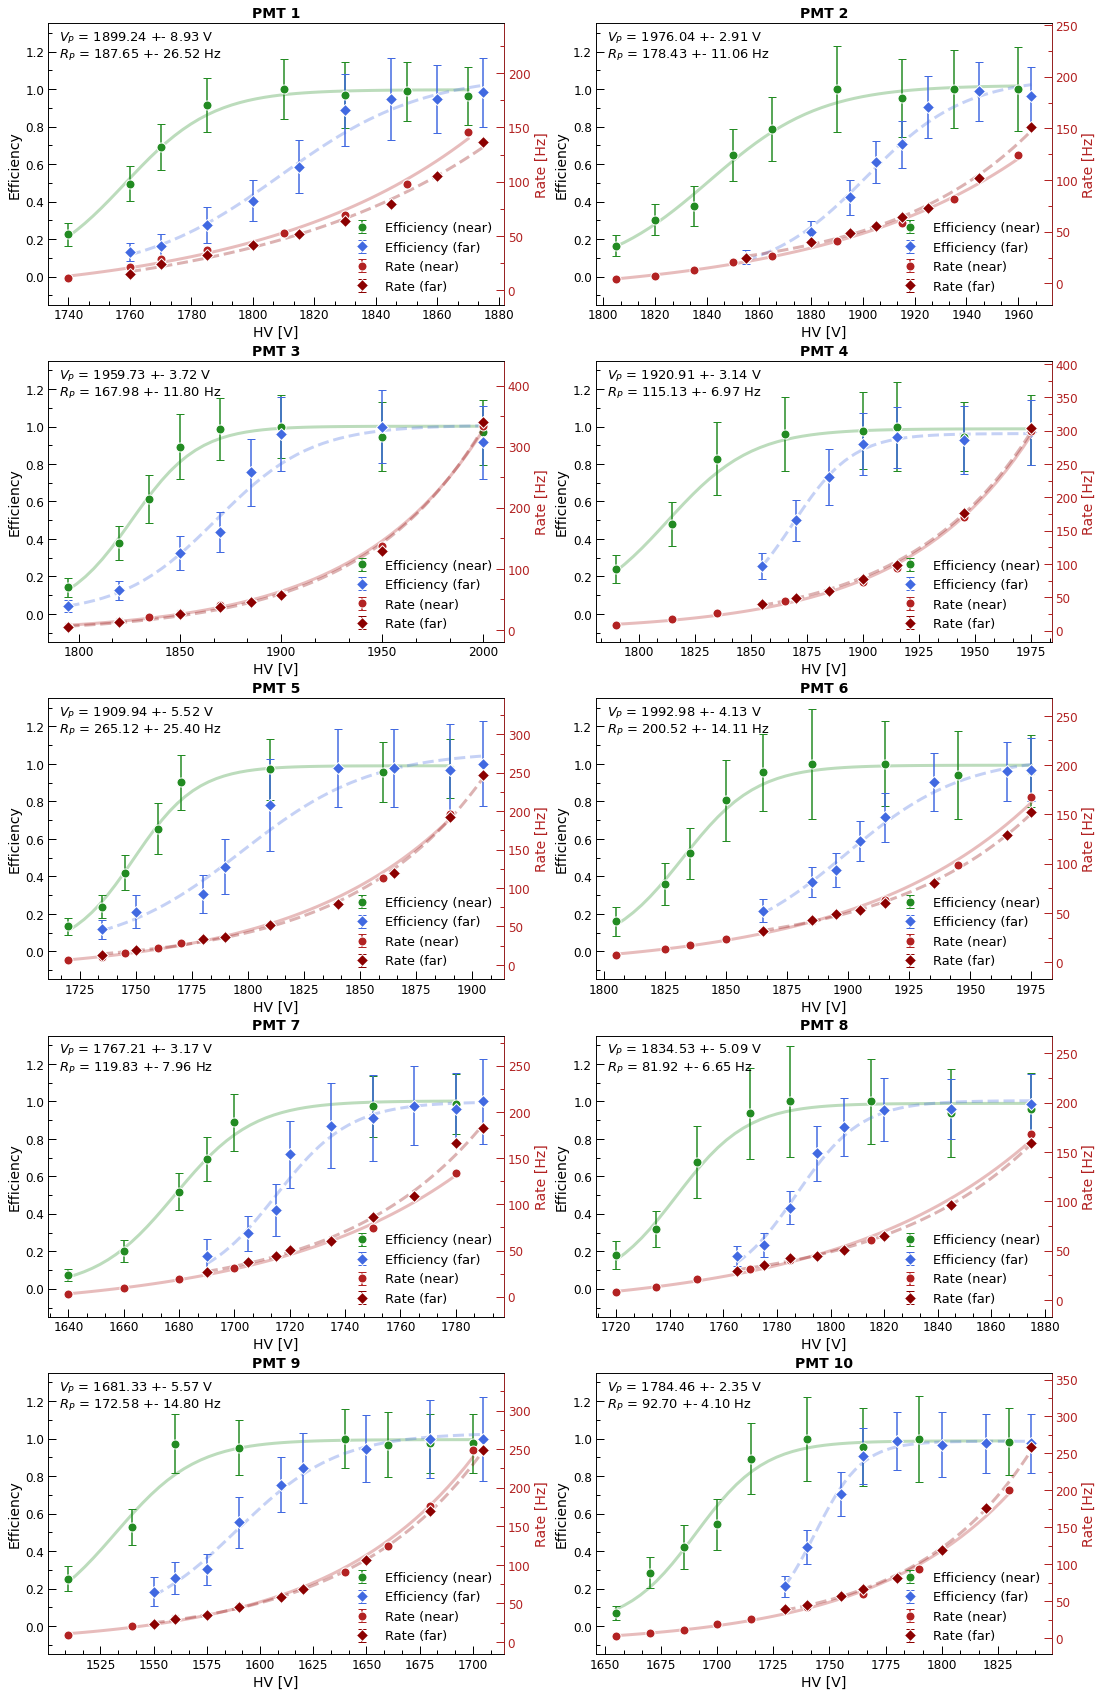

In [22]:
# data
titles = ["PMT 1", "PMT 2", "PMT 3", "PMT 4", "PMT 5", "PMT 6", "PMT 7", "PMT 8", "PMT 9", "PMT 10"]
files = ["data_PMT1_near.dat", "data_PMT1_far.dat", "data_PMT2_near.dat", "data_PMT2_far.dat", "data_PMT3_near.dat", "data_PMT3_far.dat",
         "data_PMT4_near.dat", "data_PMT4_far.dat", "data_PMT5_near.dat", "data_PMT5_far.dat", "data_PMT6_near.dat", "data_PMT6_far.dat",
         "data_PMT7_near.dat", "data_PMT7_far.dat", "data_PMT8_near.dat", "data_PMT8_far.dat", "data_PMT9_near.dat", "data_PMT9_far.dat",     
         "data_PMT10_near.dat", "data_PMT10_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 30), ncols=2, nrows=5)
plot_efficiency_both(ax[0, 0], files[0], files[1], titles[0], "results_PMT.txt")
plot_efficiency_both(ax[0, 1], files[2], files[3], titles[1], "results_PMT.txt")
plot_efficiency_both(ax[1, 0], files[4], files[5], titles[2], "results_PMT.txt")
plot_efficiency_both(ax[1, 1], files[6], files[7], titles[3], "results_PMT.txt")
plot_efficiency_both(ax[2, 0], files[8], files[9], titles[4], "results_PMT.txt")
plot_efficiency_both(ax[2, 1], files[10], files[11], titles[5], "results_PMT.txt")
plot_efficiency_both(ax[3, 0], files[12], files[13], titles[6], "results_PMT.txt")
plot_efficiency_both(ax[3, 1], files[14], files[15], titles[7], "results_PMT.txt")
plot_efficiency_both(ax[4, 0], files[16], files[17], titles[8], "results_PMT.txt")
plot_efficiency_both(ax[4, 1], files[18], files[19], titles[9], "results_PMT.txt")

# save
fig.savefig("plots/PMT_characterization.pdf")

## Lateral PMTs - 11 & 14

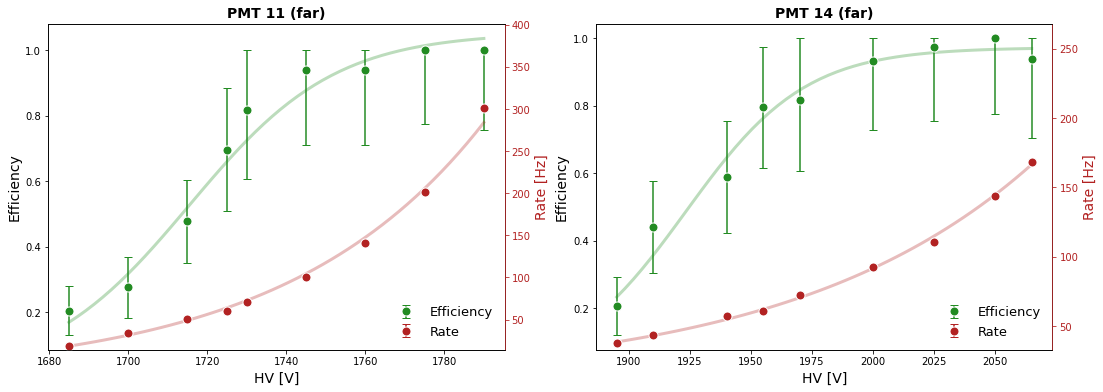

In [100]:
# data
titles = ["PMT 11 (far)", "PMT 14 (far)"]
files = ["data_PMT11_far.dat", "data_PMT14_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)
plot_efficiency(ax[0], files[0], titles[0], False)
plot_efficiency(ax[1], files[1], titles[1], False)


# save
fig.savefig("plots/plot_single_11-14.pdf")

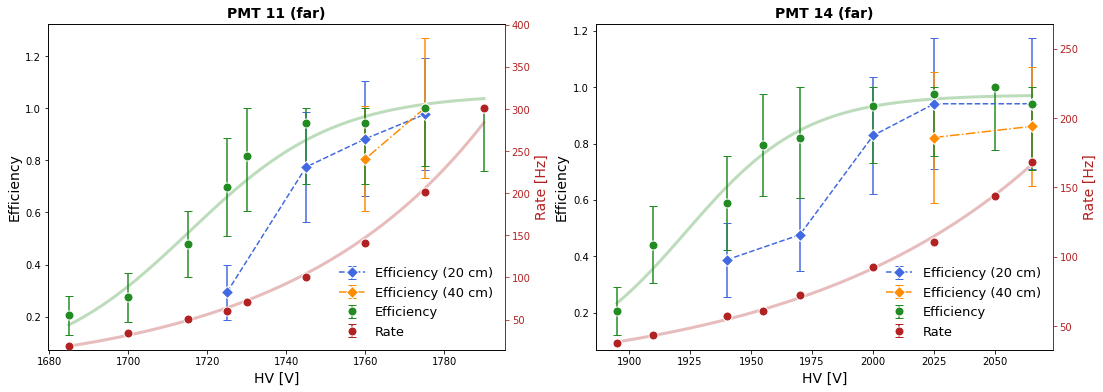

In [101]:
# data
titles = ["PMT 11 (far)", "PMT 14 (far)"]
files = ["data_PMT11_far.dat", "data_PMT14_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)

x, _, _, _, eff, _, _, _, s_eff, rate, s_rate = np.loadtxt("data_PMT11_far_20cm.dat", unpack=True)
ax[0].errorbar(x, eff, yerr=s_eff, marker='D', mec='white', markersize=9, 
                color='royalblue', linestyle='--', capsize=4, label='Efficiency (20 cm)')

x, _, _, _, eff, _, _, _, s_eff, rate, s_rate = np.loadtxt("data_PMT14_far_20cm.dat", unpack=True)
ax[1].errorbar(x, eff, yerr=s_eff, marker='D', mec='white', markersize=9, 
                color='royalblue', linestyle='--', capsize=4, label='Efficiency (20 cm)')

x, _, _, _, eff, _, _, _, s_eff, rate, s_rate = np.loadtxt("data_PMT11_far_40cm.dat", unpack=True)
ax[0].errorbar(x, eff, yerr=s_eff, marker='D', mec='white', markersize=9, 
                color='darkorange', linestyle='-.', capsize=4, label='Efficiency (40 cm)')

x, _, _, _, eff, _, _, _, s_eff, rate, s_rate = np.loadtxt("data_PMT14_far_40cm.dat", unpack=True)
ax[1].errorbar(x, eff, yerr=s_eff, marker='D', mec='white', markersize=9, 
                color='darkorange', linestyle='-.', capsize=4, label='Efficiency (40 cm)')

plot_efficiency(ax[0], files[0], titles[0], False)
plot_efficiency(ax[1], files[1], titles[1], False)

## Lateral PMTs - 12 & 13

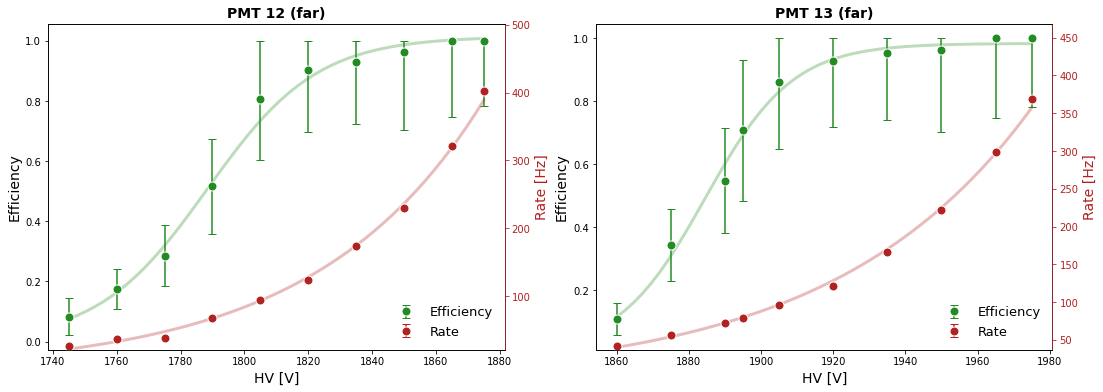

In [102]:
# data
titles = ["PMT 12 (far)", "PMT 13 (far)"]
files = ["data_PMT12_far.dat", "data_PMT13_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)
plot_efficiency(ax[0], files[0], titles[0], False)
plot_efficiency(ax[1], files[1], titles[1], False)

# save
fig.savefig("plots/plot_single_12-13.pdf")

## PMT 1 (near): tentative changes

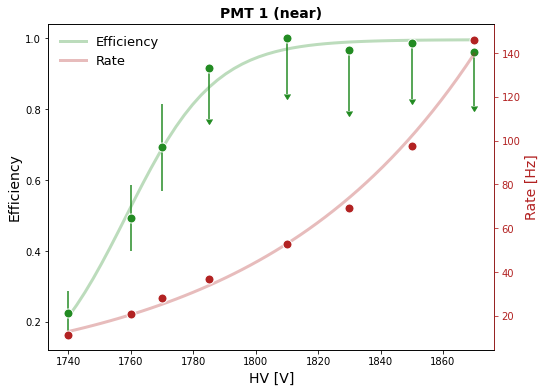

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
plot_efficiency(ax, "data_PMT1_near.dat", "PMT 1 (near)")

## Grouped - 20220420

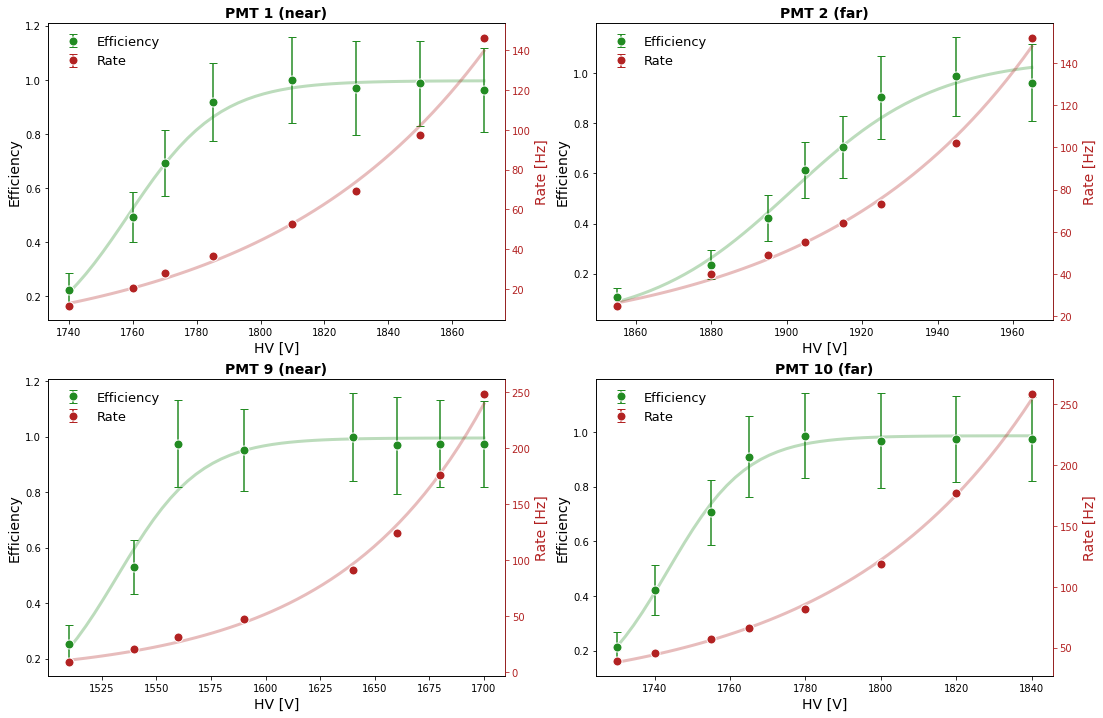

In [72]:
# data
titles = ["PMT 1 (near)", "PMT 2 (far)", "PMT 9 (near)", "PMT 10 (far)"]
files = ["data_PMT1_near.dat", "data_PMT2_far.dat", "data_PMT9_near.dat", "data_PMT10_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)

plot_efficiency(ax[0, 0], files[0], titles[0], False)
plot_efficiency(ax[0, 1], files[1], titles[1], False)
plot_efficiency(ax[1, 0], files[2], titles[2], False)
plot_efficiency(ax[1, 1], files[3], titles[3], False)

# save
fig.savefig("plots/plot_20220420.pdf")


## Grouped - 20220421

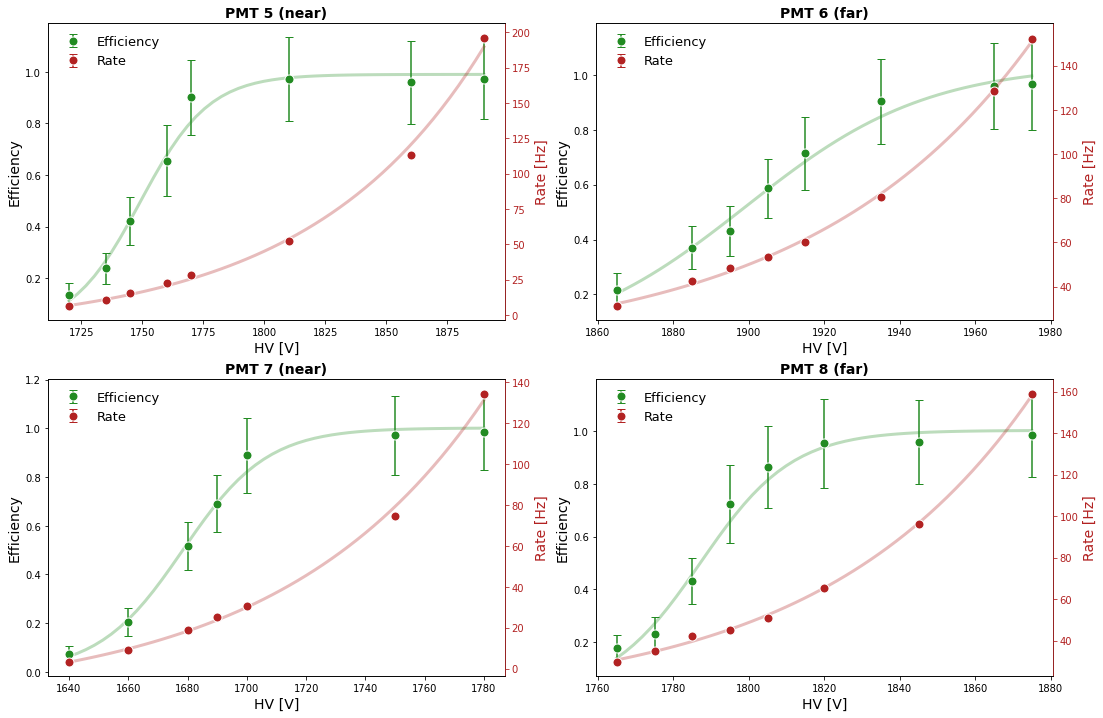

In [75]:
# data
titles = ["PMT 5 (near)", "PMT 6 (far)", "PMT 7 (near)", "PMT 8 (far)"]
files = ["data_PMT5_near.dat", "data_PMT6_far.dat", "data_PMT7_near.dat", "data_PMT8_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 12), ncols=2, nrows=2)
plot_efficiency(ax[0, 0], files[0], titles[0], False)
plot_efficiency(ax[0, 1], files[1], titles[1], False)
plot_efficiency(ax[1, 0], files[2], titles[2], False)
plot_efficiency(ax[1, 1], files[3], titles[3], False)

# save
fig.savefig("plots/plot_20220421.pdf")

# Grouped - 20220426

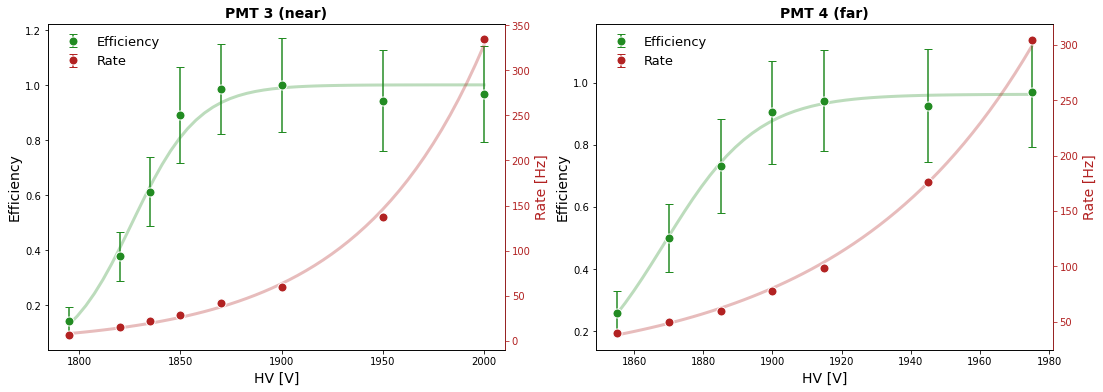

In [76]:
# data
titles = ["PMT 3 (near)", "PMT 4 (far)"]
files = ["data_PMT3_near.dat", "data_PMT4_far.dat"]

# plot
fig, ax = plt.subplots(figsize=(18, 6), ncols=2)
plot_efficiency(ax[0], files[0], titles[0], False)
plot_efficiency(ax[1], files[1], titles[1], False)

# save
fig.savefig("plots/plot_20220426.pdf")